In [3]:
import pickle
import os
from collections import Iterable
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set()
plt.rcParams.update({'font.size': 22})

<ipython-input-3-f22033fd6734>:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [10]:
def flatten(lis):
     for item in lis:
        if isinstance(item, Iterable) and not isinstance(item, str):
            for x in flatten(item):
                yield x
        else:        
            yield item
            
def find(lst, s):
    return [i for i, x in enumerate(lst) if x==s]

def keys_exists(element, *keys):
    '''
    Check if *keys (nested) exists in `element` (dict).
    '''
    if not isinstance(element, dict):
        raise AttributeError('keys_exists() expects dict as first argument.')
    if len(keys) == 0:
        raise AttributeError('keys_exists() expects at least two arguments, one given.')

    _element = element
    for key in keys:
        try:
            _element = _element[key]
        except KeyError:
            return False
    return True

In [11]:
dataset = 'prison'

In [57]:
def compute_aggreated_results(algorithm, dataset):
    results_dict={}
    for file in [path for path in os.listdir('./') if algorithm in path and dataset in path]:
        with open(f'./{file}', 'rb') as handle:
            flatten_file_name = list(flatten([i.split('.') for i in file.split('_')]))
            idx_dataset_name = find(flatten_file_name, dataset)[0]
            sample = flatten_file_name[idx_dataset_name+1:-1][-1]
            version = flatten_file_name[idx_dataset_name+1:-1][-2]
            transformation = '_'.join(flatten_file_name[idx_dataset_name+1:-1][:-2])
            if not keys_exists(results_dict, transformation):
                results_dict[transformation] = {}
            if not keys_exists(results_dict, transformation, version): 
                results_dict[transformation][version] = {}
            if not keys_exists(results_dict, transformation, version, sample):    
                results_dict[transformation][version][sample] = {}

            results_dict[transformation][version][sample] = pickle.load(handle)
        handle.close()

    # shape=(transformation, version, sample, metric, dim)
    # metric = mase, rmse
    # dim = bottom, total, state, gender, legal, all

    df = pd.DataFrame.from_dict({(i,j, k, l): results_dict[i][j][k][l] 
                               for i in results_dict.keys() 
                               for j in results_dict[i].keys()
                               for k in results_dict[i][j].keys()
                               for l in results_dict[i][j][k].keys()},
                           orient='index')

    df_mase = df[np.in1d(df.index.get_level_values(3), ['mase'])]
    df_clean = df_mase.mean(level=(0,1,2)).stack(level=0).to_frame()
    df_clean = df_clean.reset_index()
    df_clean.columns = ['transformation', 'version', 'sample', 'group', 'mase']
    
    # Calculate percentage change
    df = df_clean.copy()
    s = df.set_index(['transformation', 'version', 'sample', 'group']).mase.unstack('version')
    df = df.set_index(['transformation', 'version', 'sample', 'group'])
    df_pct = pd.DataFrame(s.div(s['orig'].groupby(['transformation', 'group']).transform(lambda x: x.fillna(x.sum())), axis='rows').sub(1).stack()).reset_index().set_index(['transformation', 'version', 'sample', 'group'])
    df_pct = df_pct.rename(columns={0: 'pct_change'})
    df_updated = df.merge(df_pct, how='left', left_index=True, right_index=True)
    
    # Calculate relative change
    df = df_clean.copy()
    s = df.set_index(['transformation', 'version', 'sample', 'group']).mase.unstack('version')
    df = df.set_index(['transformation', 'version', 'sample', 'group'])
    df_rel = pd.DataFrame(s.sub(s['orig']
                                .groupby(['transformation', 'group'])
                                .transform(lambda x: x.fillna(x.sum())), axis='rows')
                          .stack()).reset_index().set_index(['transformation', 'version', 'sample', 'group'])
    df_rel = df_rel.rename(columns={0: 'rel_change'})
    df_new = df_updated.merge(df_rel, how='left', left_index=True, right_index=True)
    df_new = df_new.reset_index()
    
    return df_new

def plot_results(df):
    _, ax = plt.subplots(2, 2, figsize=(20, 20))
    ax = ax.ravel()
    transf = df.transformation.unique()
    transf.sort()
    for i in range(len(transf)):
        fg = sns.lineplot(x='version', y='mase', hue='group', marker='o', data=df.loc[df['transformation']==transf[i]].sort_values(['version', 'group']), ax=ax[i])
        ax[i].set_ylim(0, 6.0)
        ax[i].set_title(transf[i], fontsize=22)
        
def plot_results_perc_diff(df):
    _, ax = plt.subplots(2, 2, figsize=(20, 20))
    ax = ax.ravel()
    transf = df.transformation.unique()
    transf.sort()
    for i in range(len(transf)):
        fg = sns.lineplot(x='version', y='pct_change', hue='group', marker='o', data=df.loc[df['transformation']==transf[i]].sort_values(['version', 'group']), ax=ax[i])
        ax[i].set_ylim(-0.5, 2.5)
        ax[i].set_title(transf[i], fontsize=22)
        
def plot_results_joint(df1, df2, df3, y='mase'):
    
    if y=='mase':
        ylim=(0, 6)
    elif y=='pct_change':
        ylim=(-0.5, 2.5)
    elif y=='rel_change':
        ylim=(-1, 3.5)
        
    _, ax = plt.subplots(4, 3, figsize=(40, 20))
    transf = df1.transformation.unique()
    transf.sort()
    for i in range(len(transf)):
        fg = sns.lineplot(x='version', 
                          y=y, 
                          hue='group', 
                          marker='o', 
                          data=df1.loc[df1['transformation']==transf[i]].sort_values(['version', 'group']), 
                          ax=ax[i, 0])
        ax[i,0].set_ylim(*ylim)
        ax[i,0].set_title(transf[i], fontsize=22)

    transf = df2.transformation.unique()
    transf.sort()
    for i in range(len(transf)):

        fg = sns.lineplot(x='version', 
                          y=y, 
                          hue='group', 
                          marker='o', 
                          data=df2.loc[df2['transformation']==transf[i]].sort_values(['version', 'group']), 
                          ax=ax[i,1])        
        ax[i,1].set_ylim(*ylim)
        ax[i,1].set_title(transf[i], fontsize=22)
    
    transf = df3.transformation.unique()
    transf.sort()  
    for i in range(len(transf)):
        fg = sns.lineplot(x='version', 
                          y=y, 
                          hue='group', 
                          marker='o', 
                          data=df3.loc[df3['transformation']==transf[i]].sort_values(['version', 'group']), 
                          ax=ax[i,2])        
        ax[i,2].set_ylim(*ylim)
        ax[i,2].set_title(transf[i], fontsize=22)
        
    plt.tight_layout()

In [58]:
df_gpf = compute_aggreated_results('gpf', 'prison')
df_mint = compute_aggreated_results('mint', 'prison')
df_deepar = compute_aggreated_results('deepar', 'prison')

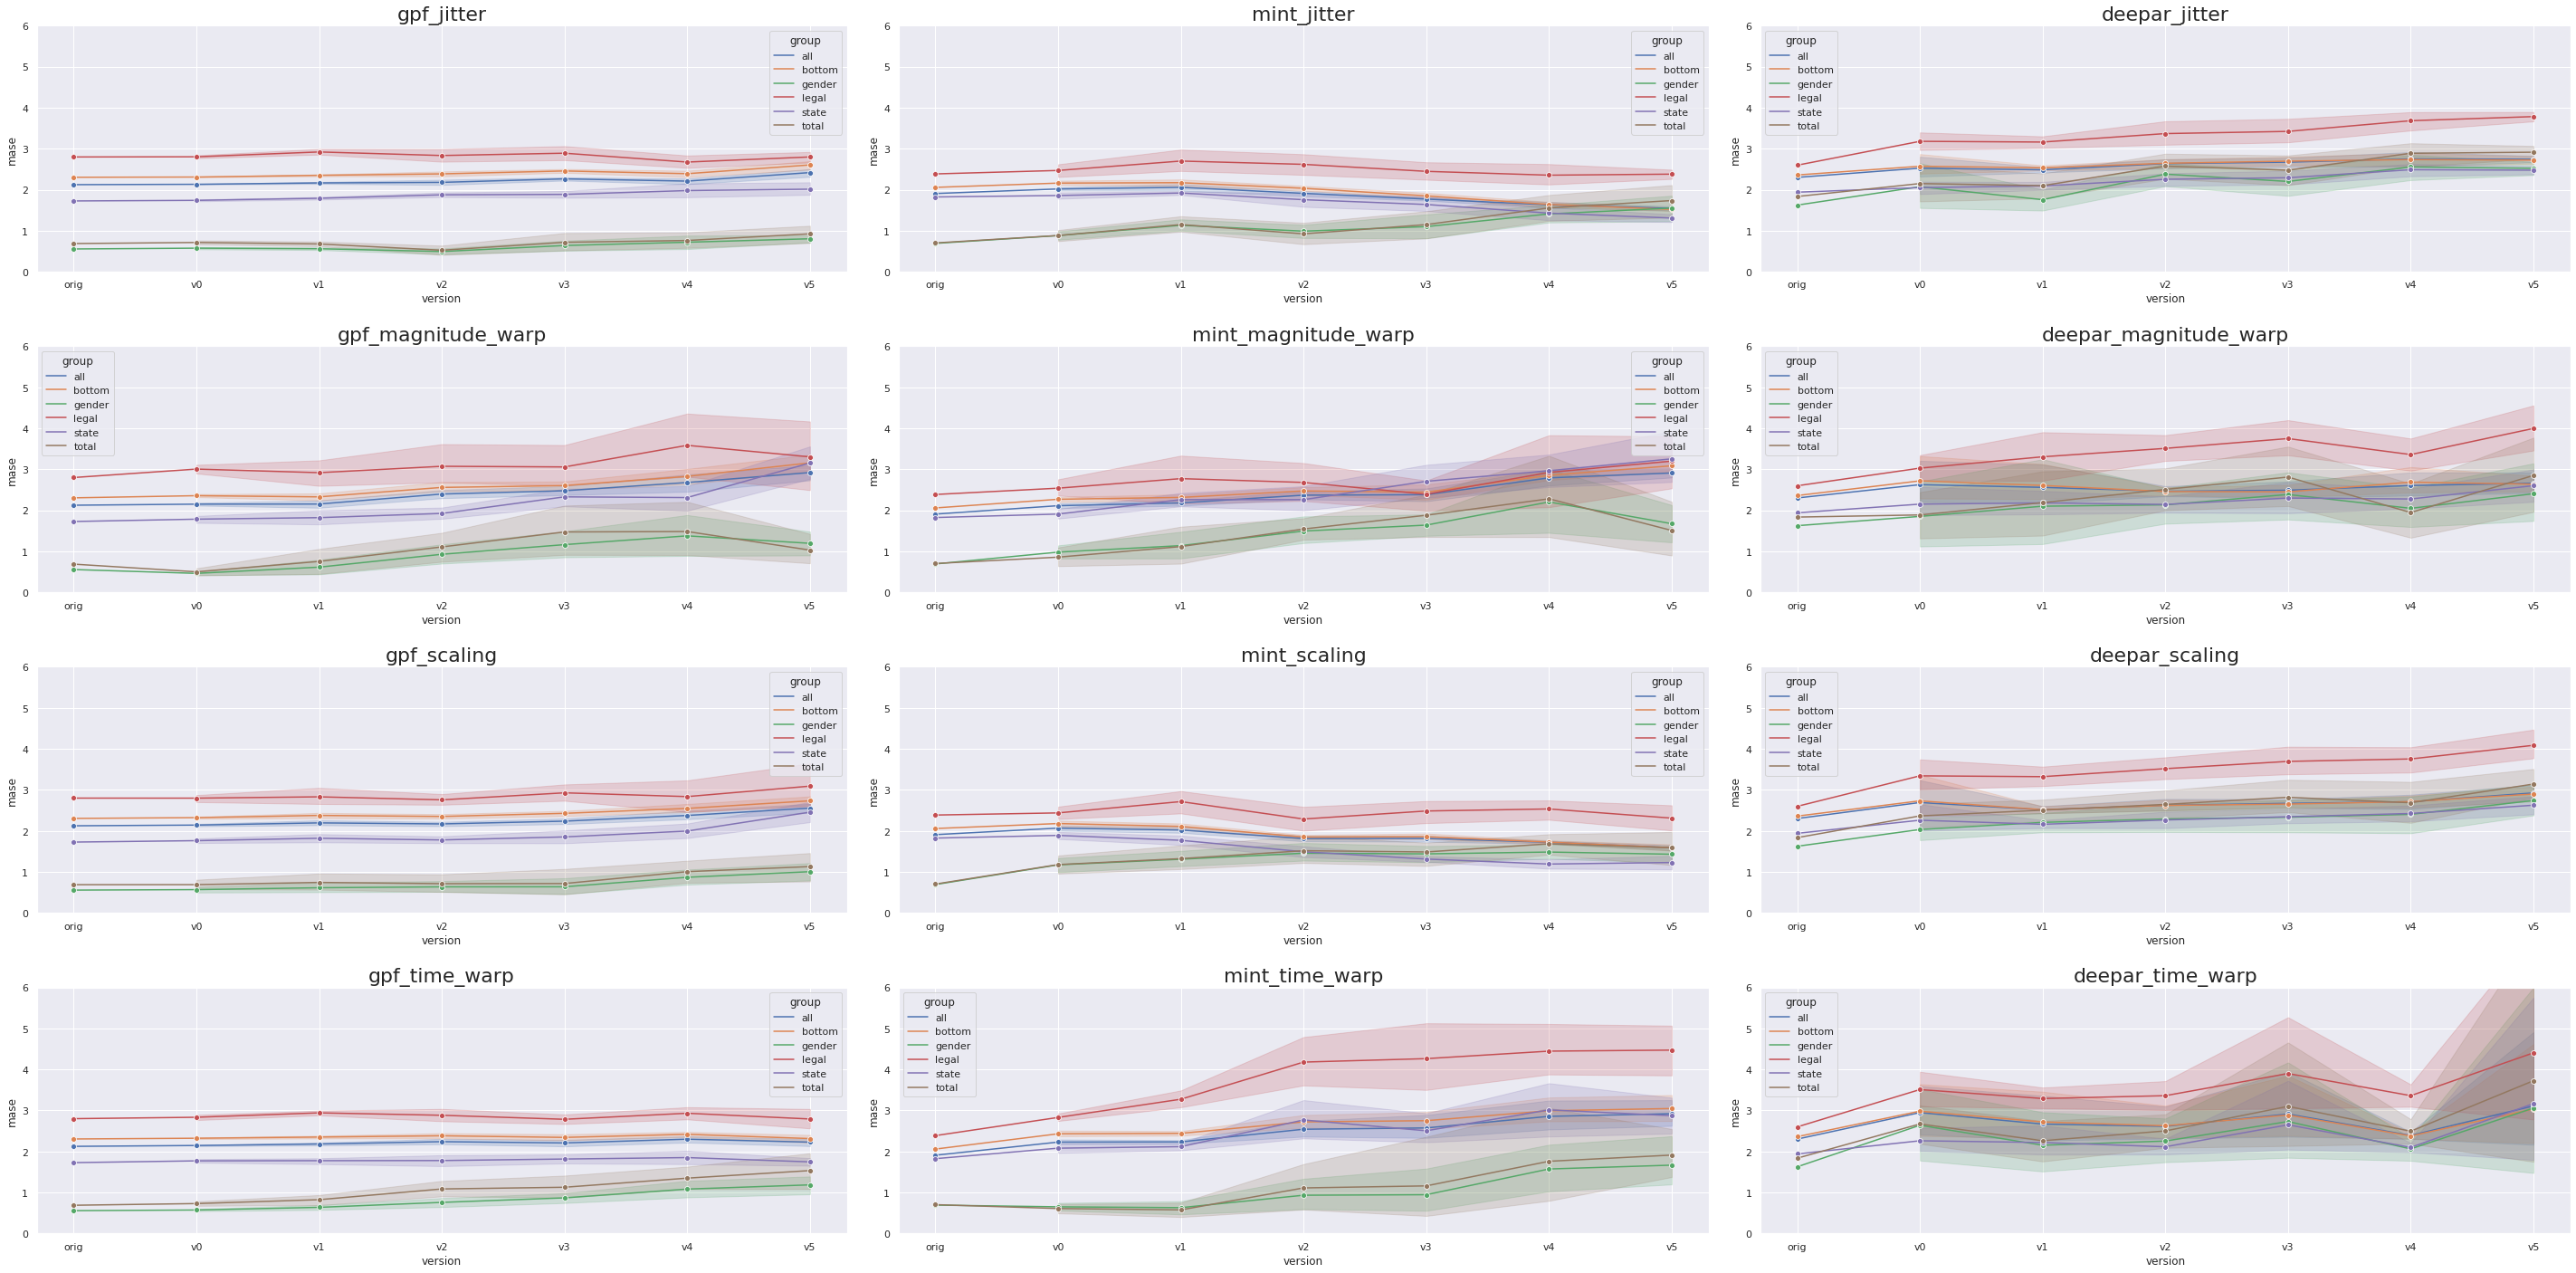

In [59]:
plot_results_joint(df_gpf, df_mint, df_deepar, 'mase')

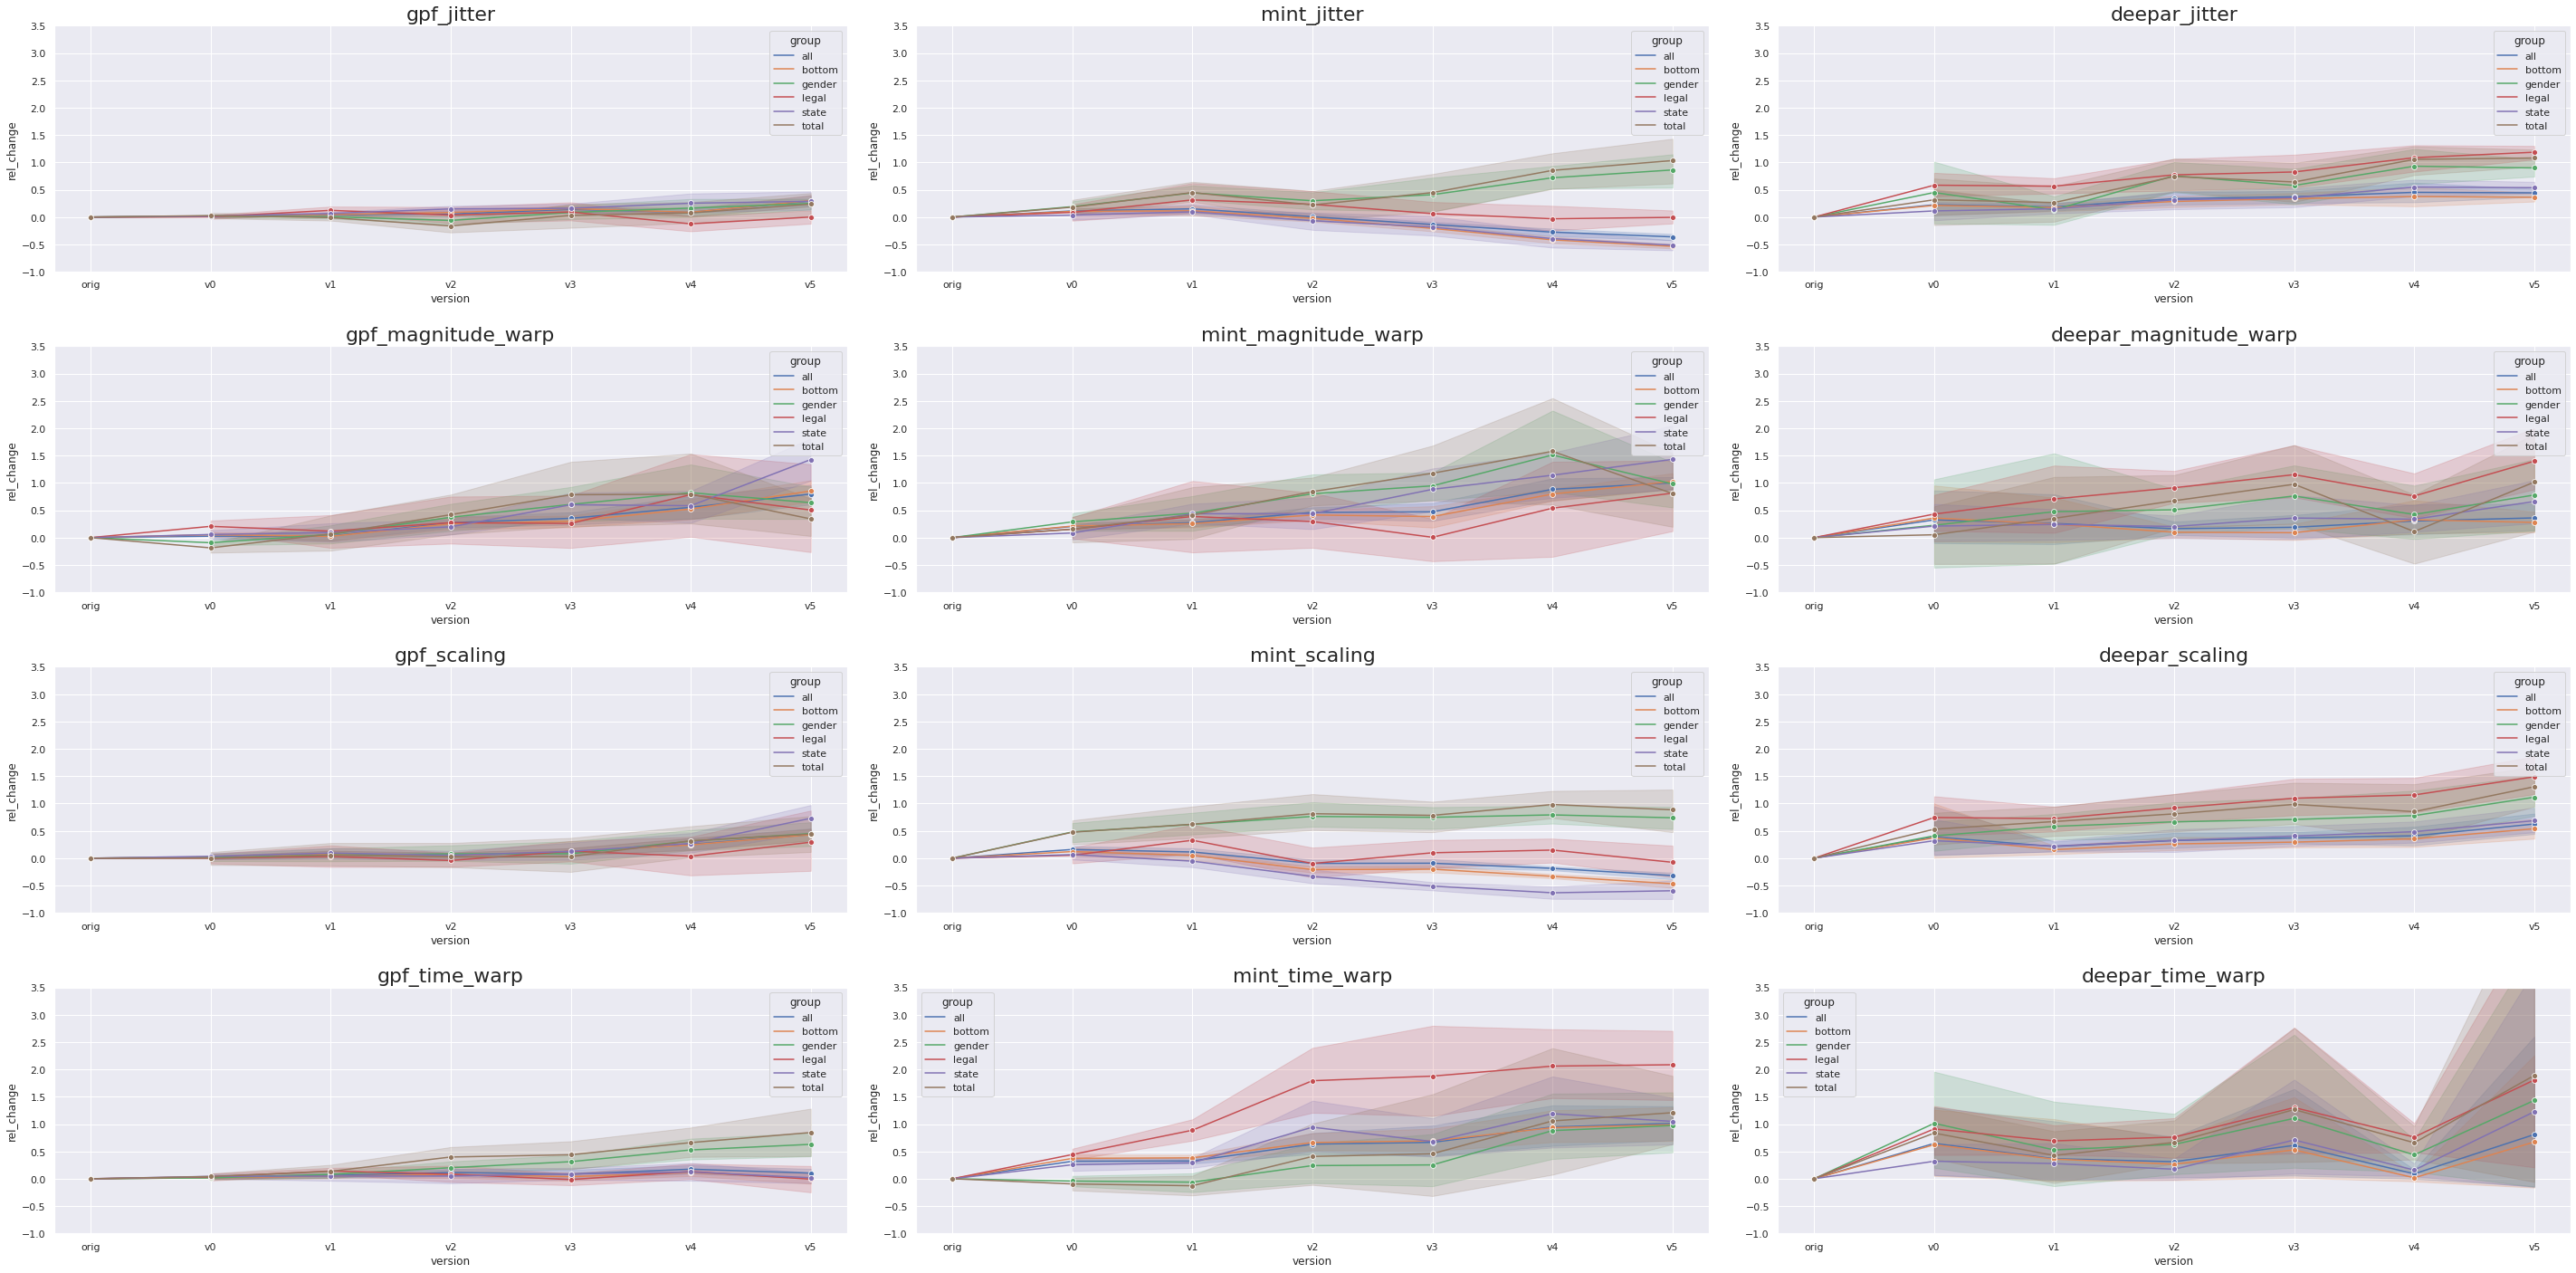

In [60]:
plot_results_joint(df_gpf, df_mint, df_deepar, 'rel_change')

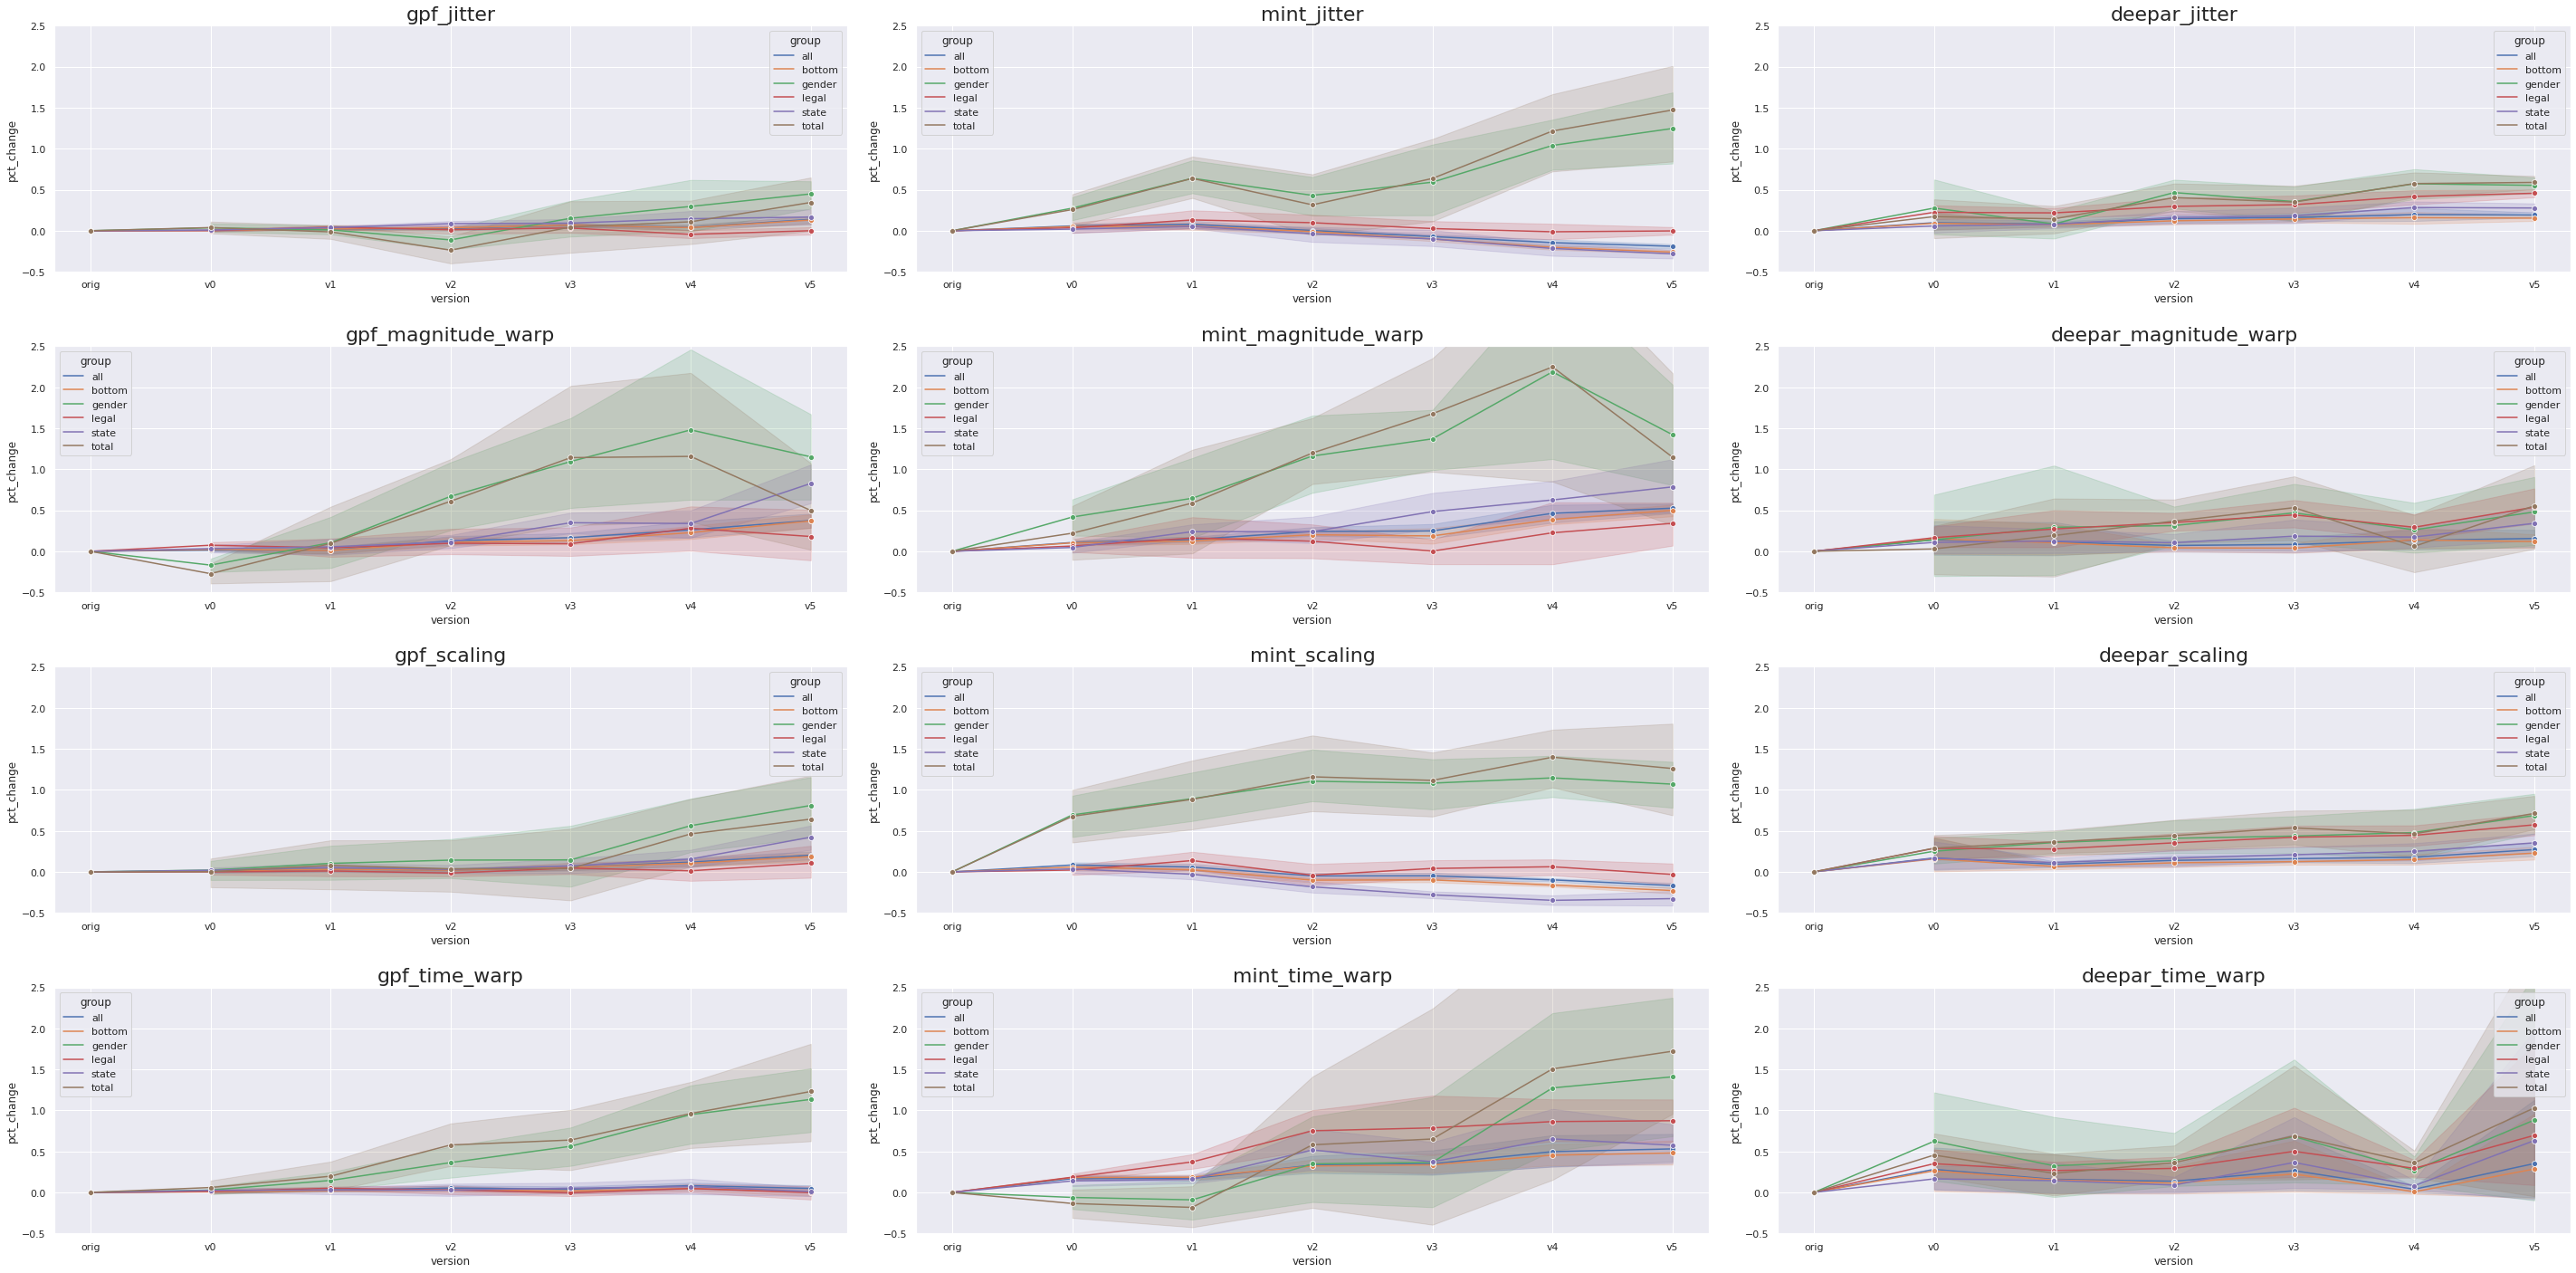

In [61]:
plot_results_joint(df_gpf, df_mint, df_deepar, 'pct_change')